# 프로젝트 : CIFAR-10 이미지 생성하기
## 개요
FASHION-MNIST 데이터 생성용 DCGAN 모델구조를 이용해서 CIFAR-10 데이터를 생성하는 모델을 직접 만들어 봅니다.   
모델 구현 및 학습의 전과정의 흐름은 거의 비슷하겠지만, 아래와 같이 몇 가지 달라지는 점이 있습니다.   

- 이미지 데이터의 shape가 (28, 28, 1)에서 (32, 32, 3)으로 변경됩니다. 생성자, 판별자 모델의 입출력 shape 및 모델 구조에 영향이 있습니다.
- 이미지가 단색의 grayscale에서 RGB 3채널의 컬러이미지로 변경됩니다. 시각화 과정에서 고려할 점이 있습니다.
- 입력데이터 전체 차원이 3~4배 증가하면서, 학습이 진행되는 양상이 다소 달라집니다.

## 목차
- STEP 1. 작업환경 구성하기
- STEP 2. 데이터셋 구성하기
- STEP 3. 생성자 모델 구현하기
- STEP 4. 판별자 모델 구현하기
- STEP 5. 손실함수와 최적화 함수 구현하기
- STEP 6. 훈련과정 상세 기능 구현하기
- STEP 7. 학습 과정 진행하기
- STEP 8. (optional) GAN 훈련 과정 개선하기

## 회고

## Reference

---

In [5]:
# 주요 라이브러리 버전 확인

import tensorflow as tf
import imageio

print(tensorflow.__version__)
print(imageio.__version__)

2.6.0
2.9.0


## STEP 1. 작업환경 구성하기
shell에서 아래의 코드로 generated_samples, training_checkpoints, training_history 폴더 생성

In [6]:
# $ mkdir -p ~/aiffel/dcgan_newimage/cifar10/generated_samples
# $ mkdir -p ~/aiffel/dcgan_newimage/cifar10/training_checkpoints
# $ mkdir -p ~/aiffel/dcgan_newimage/cifar10/training_history

In [8]:
# 패키지 불러오기
import os     # 운영 체제와 상호 작용하기 위한 os 모듈
import glob   # 파일 경로에 대한 패턴 매칭을 위한 glob 모듈
import time   # 시간과 관련된 기능을 사용하기 위한 time 모듈

import PIL          # 이미지 처리를 위한 Python Imaging Library인 PIL(Pillow)
import imageio      # 이미지 입출력을 위한 imageio 모듈
import numpy as np  # 다차원 배열 및 수학적 연산을 위한 NumPy 라이브러리
import tensorflow as tf
from tensorflow.keras import layers    # TensorFlow의 Keras API에서 층을 정의하는 데 사용되는 layers 모듈
from IPython import display            # IPython의 display 모듈에서 display 함수. 주로 이미지나 동적인 콘텐츠를 출력하기 위해 사용
import matplotlib.pyplot as plt        # 데이터 시각화를 위한 Matplotlib 라이브러리에서 pyplot 모듈
%matplotlib inline
# IPython 환경에서 Matplotlib의 그림을 인라인으로 표시하도록 하는 IPython 매직 명령어

print("tensorflow", tf.__version__)

tensorflow 2.6.0


## STEP 2. 데이터셋 구성하기

### 데이터셋 불러오기
CIFAR-10 데이터셋도 tf.keras 안에 있는 datasets에 포함되어 있어서, 아래와 같이 손쉽게 데이터셋을 구성할 수 있습니다.

In [9]:
# 데이터셋 불러오기

cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

(50000, 32, 32, 3)

- dataset 크기 : training images 50,000장 / test images 10,000장
- image size : 32x32
- 10 classes
- [공식문서 참조](https://www.tensorflow.org/datasets/catalog/cifar10)

### 이미지 픽셀 정규화

In [10]:
# 이미지의 픽셀 범위 확인
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0


학습에 사용할 train_x의 이미지를 -1 ~ 1로 정규화합니다.

In [11]:
# 픽셀 값 정규화 : -1에서 1사이의 값으로
train_x = (train_x - 127.5) / 127.5

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


In [12]:
# 데이터의 shape 확인
train_x.shape

(50000, 32, 32, 3)

### 데이터 시각화로 이미지 확인
로드한 학습 데이터를 시각화를 통해 확인해 봅시다.

In [17]:
# 첫 번째 데이터를 꺼내서 어떻게 생겼는지 확인
plt.imshow(train_x[0].reshape(32, 32), cmap='rgb')
plt.colorbar()   # 각 픽셀의 값과 그에 따른 색을 확인
plt.show()

ValueError: cannot reshape array of size 3072 into shape (32,32)

> - shape 오류가 발생하였습니다.  
> 채널 수를 포함하여 reshape 합니다.  

> - 적절한 rgb 적용이 필요해 보입니다.  
> ListedColormap를 사용하여 명시적으로 빨강, 녹색, 파랑 순서의 색상을 지정했습니다.  
> 이 방법은 선형 및 비선형적인 변화를 모두 표현할 수 있으며, 리스트에 지정된 순서대로 컬러가 할당됩니다. 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


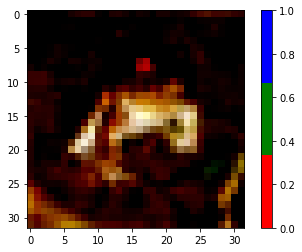

In [22]:
from matplotlib.colors import ListedColormap

# 사용자 정의 'rgb' 스타일 컬러맵 정의
cmap_rgb = ListedColormap(['red', 'green', 'blue'])

# 이미지 플로팅
plt.imshow(train_x[0].reshape(32, 32, 3), cmap=cmap_rgb)
plt.colorbar()
plt.show()

- 이미지 데이터의 shape이 적절하게 설정되어 있으며, RGB 표현 시 cmap은 설정하지 않아도 되는 것을 확인하여 아래와 같이 수정하였습니다.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


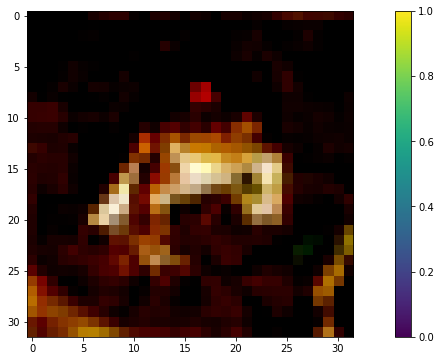

In [62]:
# 첫 번째 데이터를 꺼내서 어떻게 생겼는지 확인
plt.imshow(train_x[0])
# 컬러 별 픽셀 값 확인
plt.colorbar()
# 이미지 보기
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

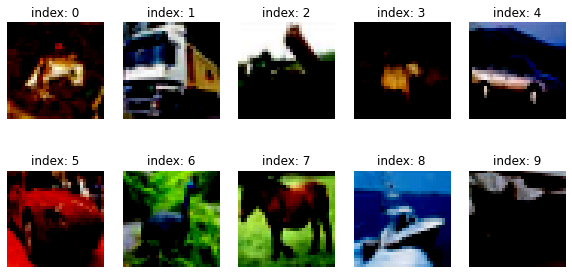

In [63]:
# 10개 데이터 한 번에 확인하기 - for문 활용

plt.figure(figsize=(10, 5))   # 이미지의 전체 프레임의 크기를 결정

for i in range(10):
    plt.subplot(2, 5, i+1)   # 여러 개의 이미지를 한 번에 띄우고 싶을 때에는 plt.subplot(row, col, index)의 형태로 확인
    plt.imshow(train_x[i])
    plt.title(f'index: {i}')
    plt.axis('off')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

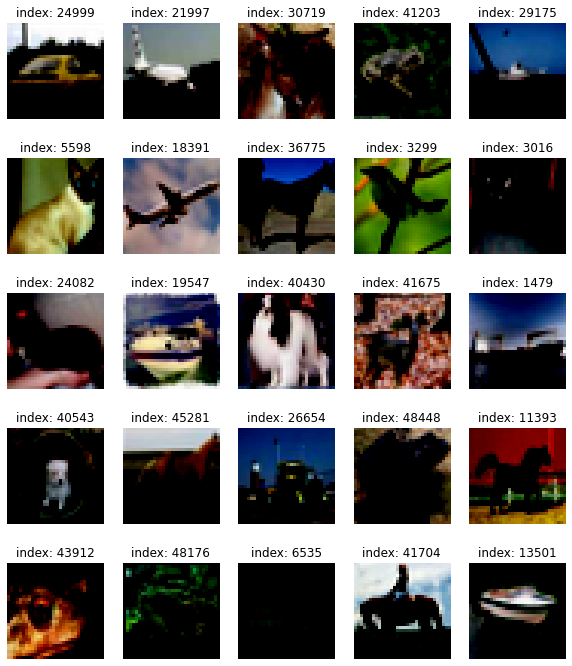

In [64]:
# 이미지 25개를 5x5 배열로 띄워보기. 모든 이미지는 train_images에서 랜덤으로 추출하기.
# (numpy에서 랜덤으로 정수를 추출해 주는 함수를 활용)

plt.figure(figsize=(10, 12))

for i in range(25):
    plt.subplot(5, 5, i+1)
    random_index = np.random.randint(1, 50000)
    plt.imshow(train_x[random_index])
    plt.title(f'index: {random_index}')
    plt.axis('off')

plt.show()

### 미니배치 데이터셋 구성
tf.data.Dataset 모듈의 from_tensor_slices() 함수를 사용하여 미니배치 데이터셋을 구성해 봅시다.  
BUFFER_SIZE는 총 데이터 개수인 50000개보다 넉넉하게 60000개로 설정해보겠습니다.

In [27]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [28]:
# 미니 배치 학습 
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [29]:
# # 참고용 코드 - 한 종류의 데이터만 추출하여 진행하기

# def load_data(label=None):
#     (train_x, train_y), (test_x, test_y) = tf.keras.datasets.cifar10.load_data()
#     if label:
#         df = pd.DataFrame(list(zip(train_x, train_y)), columns=['image', 'label']) 
#         df = df[df['label']==label]
#         train_x = np.array([i for i in list(df['image'])])
#         df = pd.DataFrame(list(zip(test_x, test_y)), columns =['image', 'label']) 
#         df = df[df['label']==label]
#         test_x = np.array([i for i in list(df['image'])])
#     return train_x, test_x

## STEP 3. 생성자 모델 구현하기
### 생성자 모델 구현 함수
(32, 32, 3)의 shape를 가진 이미지를 생성하는 생성자 모델 구현 함수를 작성해 봅시다.

In [35]:
# 생성자 모델(generator model) 구현

def make_generator_model():

	# Start
	model = tf.keras.Sequential()

	# First: Dense layer
	# units은 8x8x256, 편향은 사용하지 않음, 입력 값의 크기는 100차원 벡터
	model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100, )))
	# 배치 정규화 사용
	model.add(layers.BatchNormalization())
	# LeakyReLU 활성화 함수 사용
	model.add(layers.LeakyReLU())

	# Second: Reshape layer
	model.add(layers.Reshape((8, 8, 256)))
	assert model.output_shape == (None, 8, 8, 256)   # 주목: 배치사이즈로 None이 주어집니다.

	# Third: Conv2DTranspose layer
	# 커널 크기는 5, stride는 1, 패딩은 사용, 편향은 사용하지 않음
	model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
	# assert는 주어진 조건이 True인지 확인하는 데 사용되는 파이썬의 문장. False인 경우 AssertionError 예외가 발생하며, 프로그램이 중단된다.
	assert model.output_shape == (None, 8, 8, 128)
	# 배치 정규화 사용
	model.add(layers.BatchNormalization())
	# LeakyReLU 활성화 함수 사용
	model.add(layers.LeakyReLU())

	# Fourth: Conv2DTranspose layer
	# 커널 크기는 5, stride는 2, 패딩은 사용, 편향은 사용하지 않음
	model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
	assert model.output_shape == (None, 16, 16, 64)
	# 배치 정규화 사용
	model.add(layers.BatchNormalization())
	# LeakyReLU 활성화 함수 사용
	model.add(layers.LeakyReLU())

	# Fifth: Conv2DTranspose layer
	model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
										activation='tanh'))
	assert model.output_shape == (None, 32, 32, 3)

	return model

In [36]:
# 생성 모델을 generator라는 변수로 생성하고, 모델 세부 내용인 summary를 출력

generator = make_generator_model()

generator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16384)             1638400   
_________________________________________________________________
batch_normalization_3 (Batch (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16384)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_4 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 8, 8, 128)        

### 랜덤 노이즈를 입력으로, 구현한 생성자로 랜덤 이미지 생성하기

In [38]:
# 랜덤 노이즈 벡터 만들기
noise = tf.random.normal([1, 100])

In [39]:
# 랜덤 노이즈 벡터로 결과물 만들어보기
generated_image = generator(noise, training=False)
generated_image.shape


TensorShape([1, 32, 32, 3])

생성된 랜덤 이미지가 생성자 출력 규격에 잘 맞습니다.  
첫 번째 1은 1개(batch_size=1)라는 뜻을, 그 뒤로는 (32, 32, 3) 사이즈 이미지가 생성되었다는 뜻을 가집니다.

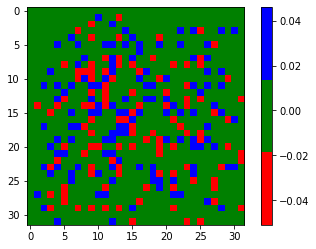

In [40]:
# 이미지 시각화

plt.imshow(generated_image[0, :, :, 0], cmap=cmap_rgb)   # 2차원 이미지만 보여줄 수 있으므로 0, 3번째 축의 인덱스 0으로 설정하여 이미지 꺼내기
plt.colorbar()
plt.show()

아직은 모델이 전혀 학습하지 않은 상태이기 때문에 아무런 의미가 없는 노이즈 같은 이미지가 생성되었습니다.  
모델이 점차 학습해 나가며 제대로 된 이미지를 생성하기를 바라봅니다.

## STEP 4. 판별자 모델 구현하기
### 판별자 모델 구현 함수
(32, 32, 3)의 이미지를 입력으로 받아 1dim 판별결과(단 하나의 숫자, 진짜라고 판단하는 정도)를 출력하는 판별자 모델 구현 함수를 작성해 봅니다.

In [41]:
# 판별자 모델 구현 (discriminator model)

def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    # 필터의 크기는 5이며 64개 사용, stride는 2, 패딩은 사용, 입력 값의 크기는 준비된 흑백 사진
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    # LeakyReLU 활성화 함수 사용
    model.add(layers.LeakyReLU())
    # Dropout은 0.3을 사용
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    # 필터의 크기는 5이며 128개 사용, stride는 2, 패딩은 사용
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    # LeakyReLU 활성화 함수 사용
    model.add(layers.LeakyReLU())
    # Dropout은 0.3을 사용
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

In [42]:
# 판별 모델을 discriminator라는 변수 이름으로 생성하고, 모델 세부 내용인 summary를 출력

discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)             

### 판별자 모델이 판별한 결과값 확인
위 STEP 2에서 생성한 랜덤 이미지를 판별자 모델이 판별한 결과값을 확인해 봅시다.

In [43]:
# 아까 생성했던 가짜 이미지를 판별자에 입력하고 결과 확인해보기

decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00178711]], dtype=float32)>

텐서플로우의 텐서 형태로 출력이 되었습니다. 이 값 또한 아직은 아무런 의미가 없는 값일 것입니다.  
이제 모델 학습을 합니다.

## STEP 5. 손실함수와 최적화 함수 구현하기

In [44]:
# 판별값을 0~1 사이의 값으로 정규화할 수 있도록 설정

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### generator_loss 구현
generator_loss는 fake_output가 1에 가까워지기를 바라므로, 다음과 같이 tf.ones_like와의 교차 엔트로피값을 계산하면 됩니다.  
즉, cross_entropy(tf.ones_like(fake_output), fake_output) 값은 fake_output이 (Real Image를 의미하는) 1에 가까울수록 작은 값을 가집니다.

In [45]:
# generator loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

### discriminator_loss 구현
반면, discriminator_loss는 real_output 값은 1에 가까워지기를, fake_output 값은 0에 가까워지기를 바라므로, 두 가지 loss값을 모두 계산합니다.  
real_output은 1로 채워진 벡터와, fake_output은 0으로 채워진 벡터와 비교하면 됩니다!  

최종 discriminator_loss 값은 이 둘을 더한 값입니다.

In [46]:
# discriminator loss

def discriminator_loss(real_output, fake_output):
    # 손실함수는 cross entropy를 사용, ones_like를 활용
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    # 손실함수는 cross entropy를 사용, zeros_like를 활용
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    # real_loss와 fake_loss를 더한 값
    total_loss = real_loss + fake_loss
    return total_loss

### discriminator accuracy 구현
판별자의 출력값을 가지고 실제/생성(real/fake) 이미지 판별 정확도(accuracy)를 계산하는 함수를 구현해 봅니다.  
특히 두 accuracy를 따로 계산해서 비교해 보는 것이 매우 유용합니다.  

real accuracy와 fake accuracy는 초반에는 1.0에 가깝게 나오다가, 서서히 낮아져서 둘 다 0.5에 가까워지는 것이 이상적입니다.  
fake accuracy가 1.0에 더 가깝다면 아직은 생성자가 판별자를 충분히 잘 속이지 못하고 있다는 뜻이기 때문입니다.

In [47]:
# discriminator accuracy
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

### 최적화 함수(optimizer)
Adam 최적화 기법을 활용해 최적화 함수(생성자와 판별자를 최적화하는 optimizer)를 설정해보겠습니다.  
Adam 함수 또한 tf.keras.optimizers 안에 있습니다.
중요한 하이퍼 파라미터인 "learning rate"는 0.0001로 설정해보겠습니다.

In [48]:
# 생성자와 구분자의 optimizer 만들기

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

#### 생성자가 생성한 샘플 확인
또한, 매번 학습이 어떻게 진행되어가고 있는지를 확인하기 위해 생성자가 생성한 샘플을 확인할 것입니다.  

샘플은 한 번에 16장을 생성하도록 하겠습니다.   
생성할 샘플은 매번 같은 노이즈로 생성해야 그에 대한 진전 과정을 확인할 수 있으므로, 고정된 seed 노이즈를 만들어두어야 합니다.  
즉, 100차원의 노이즈를 총 16개, (16, 100) 형상의 벡터를 만들어 두도록 하겠습니다.

In [49]:
# 생성자가 생성한 샘플 확인하기

noise_dim = 100
num_examples_to_generate = 16    # 한 번에 몇 장의 샘플을 생성할 것인지 설정

# 고정된 seed 노이즈 만들기 : 매번 같은 노이즈로 생성하여 진전 과정을 확인할 수 있으므로
seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

## STEP 6. 훈련과정 상세 기능 구현하기
### train_step() 함수 구현
1개 미니배치의 훈련 과정을 처리하는 train_step() 함수를 구현해 봅니다.    
@tf.function 데코레이터가 사용된 함수에 입력된 입력은 Tensorflow의 graph 노드가 될 수 있는 타입으로 자동 변환됩니다.

In [50]:
# train_step 함수 구현

@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

아래는 train_step 함수의 주석입니다.  

- (1) 입력 데이터: Real Image 역할을 할 images 한 세트를 입력으로 받음
- (2) 생성자 입력 노이즈 : generator가 FAKE IMAGE를 생성하기 위한 noise를 images 한 세트와 같은 크기인 BATCH_SIZE 만큼 생성함
- (3) tf.GradientTape()는 가중치 갱신을 위한 Gradient를 자동 미분으로 계산하기 위해 with 구문 열기
- (4) generated_images 생성 : generator가 noise를 입력받은 후 generated_images 생성
- (5) discriminator 판별 : discriminator가 Real Image인 images와 Fake Image인 generated_images를 각각 입력받은 후 real_output, fake_output 출력
- (6) loss 계산 : fake_output, real_output으로 generator와 discriminator 각각의 loss 계산
- (7) accuracy 계산 : fake_output, real_output으로 discriminator의 정확도 계산
- (8) gradient 계산 : gen_tape와 disc_tape를 활용해 gradient를 자동으로 계산
- (9) 모델 학습 : 계산된 gradient를 optimizer에 입력해 가중치 갱신 (계산된 그래디언트를 이용하여 생성자와 판별자의 모델 파라미터를 업데이트)
- (10) 리턴값 : 이번 스텝에 계산된 loss와 accuracy를 리턴

### generate_and_save_images() 함수 구현
16개의 고정된 seed를 입력으로 하여 훈련 과정 동안 생성한 이미지를 시각화하는 generate_and_save_images() 함수를 구현해 봅니다.  

In [53]:
# 샘플 생성 함수 구현 (train_step과 함께 일정 간격으로 학습 현황을 볼 수 있는)

def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0], cmap=cmap_rgb)
        plt.axis('off')
   
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()


### 시각화 함수 draw_train_history() 구현
훈련 epoch마다 생성자/판별자의 loss 및 판별자의 실제/생성(real/fake) 이미지 판별 accuracy 히스토리(history)를 그래프로 시각화하는 draw_train_history() 함수를 구현해 봅니다.

In [55]:
# gen, disc의 loss, accuracy 시각화 함수 (train_step()함수가 리턴하는)

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

### 모델 checkpoint 만들기 - 모델을 정기적으로 저장
training_checkpoints 디렉토리에 몇 epoch마다 모델을 저장하는 checkpoint 모듈을 설정해 봅니다.

In [56]:
# model checkpoint 만들기

checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## STEP 7. 학습 과정 진행하기

In [57]:
# 모델 학습 함수

def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()   # 각 에폭의 시작 시간을 기록
        # 주어진 데이터셋을 이용하여 미니배치 단위로 GAN을 훈련
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            # 매 50번째 이터레이션마다 결과를 출력하고 생성된 이미지를 시각화하여 모니터링합니다.
            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)   # 각 에폭이 끝날 때마다 생성자에 의해 생성된 이미지를 시각화하여 저장
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        # 지정된 주기(save_every)마다 모델의 체크포인트를 저장
        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)   # 전체 훈련이 완료된 후에 마지막으로 생성된 이미지를 시각화하여 저장
        print('Time for training : {} sec'.format(int(time.time()-start)))   # 전체 훈련 소요 시간을 출력

        draw_train_history(history, epoch)

#### 이터레이션이란?

- GAN(Generative Adversarial Network)이나 다른 머신러닝 모델의 훈련에서, 전체 훈련 데이터셋을 한 번 훑는 것을 "에폭(epoch)"이라고 합니다. 그리고 한 번의 에폭 동안에 전체 데이터셋을 여러 번 반복하여 사용하며, 각 반복을 이터레이션이라고 합니다.
- 이터레이션의 개념은 주로 미니배치 학습(mini-batch learning)에서 사용됩니다. 미니배치 학습에서는 전체 데이터셋을 작은 미니배치로 나누어 각각의 미니배치에 대해 모델을 업데이트합니다. 이때 한 번의 미니배치에 대한 업데이트를 하나의 이터레이션이라고 부릅니다.
- 예를 들어, 1000개의 훈련 샘플이 있는 데이터셋을 사용하여 배치 크기가 50인 미니배치 학습을 한다면, 각 에폭에서 20번의 이터레이션을 거치게 됩니다. 총 이터레이션 수는 에폭 수와 미니배치 수의 곱으로 계산됩니다.

#### save_every란?
- save_every는 모델의 학습 도중 일정 주기마다 모델의 체크포인트를 저장하기 위한 매개변수입니다.
- save_every는 몇 번의 에폭(epoch)이 지날 때마다 체크포인트를 저장할 것인지를 나타냅니다.
- 예를 들어, save_every=5로 설정되어 있다면, 매 5번의 에폭이 끝날 때마다 모델의 체크포인트가 저장됩니다. 

In [58]:
save_every = 5
EPOCHS = 50

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### 모델 학습

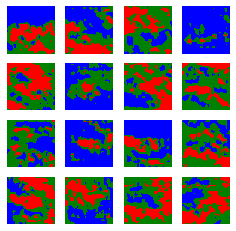

Time for training : 752 sec


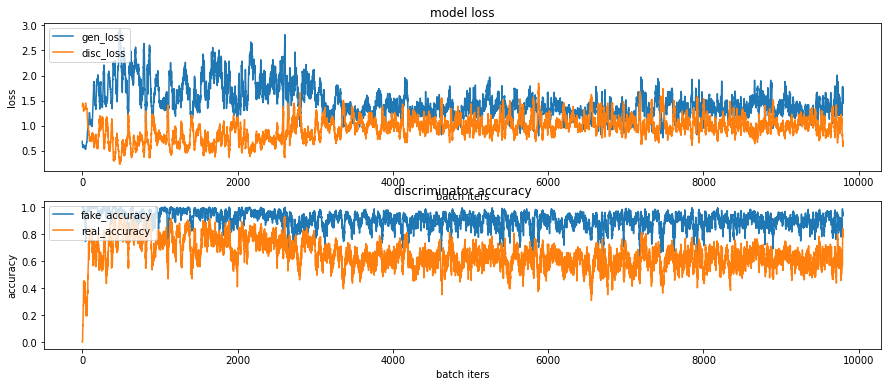

CPU times: user 12min 51s, sys: 1min 20s, total: 14min 11s
Wall time: 12min 33s


In [59]:
%%time
train(train_dataset, EPOCHS, save_every)

# 학습과정의 loss, accuracy 그래프 이미지 파일이 ~/aiffel/dcgan_newimage/cifar10/training_history 경로에 생성되고 있어
# 진행 과정을 수시로 확인할 수 있습니다.

fake_accuracy가 1에 가깝게 유지되고 있어, 생성자가 만든 이미지가 아직 판별자를 성공적으로 속이지 못하고 있는 것으로 보입니다.  
일단은 현재까지의 학습과정을 gif로 시각화해보고, 더 많은 epoch으로 학습해보겠습니다.

### 학습과정 시각화하기
학습 과정에서 생성된 샘플 이미지로 만든 gif 파일을 통해 학습 진행 과정을 시각적으로 표현해봅니다.

In [60]:
# 샘플 이미지들로 gif 파일 만들기

anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/cifar10_mnist_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/cifar10/cifar10_mnist_dcgan.gif

-rw-r--r-- 1 root root 157450 Jan 23 05:09 /aiffel/aiffel/dcgan_newimage/cifar10/cifar10_mnist_dcgan.gif


### 학습 epoch을 추가 진행하거나, 학습한 모델을 활용하여 이미지 생성 시 - checkpoint 모듈의 활용
(참고) 학습 과정 중 학습 epoch를 추가 진행해야 하거나, 학습한 모델을 활용하여 이미지를 생성할 필요가 생깁니다.   
그럴 때마다 모델 학습을 처음부터 다시 진행한다면 시간 낭비가 될 것입니다.  
우리는 위에서 checkpoint 모듈을 이용해 모델을 저장해 둔 바 있습니다.   
이를 이용해 학습해 둔 모델을 로드하면 모델 재학습이 필요 없이 이런 작업을 진행할 수 있습니다.  
아래는 checkpoint 모듈을 활용하여 모델을 로드하는 예시입니다.

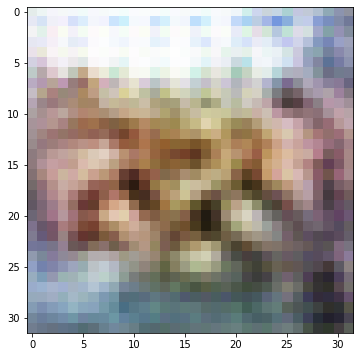

In [65]:
# 체크포인트 파일이 저장된 디렉토리 경로를 설정 
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

# 가장 최근의 체크포인트 파일 경로를 가져오기
latest = tf.train.latest_checkpoint(checkpoint_dir)
# 가져온 최근의 체크포인트로부터 모델의 가중치를 복원
checkpoint.restore(latest)

# 복원된 모델에서 생성자(generator)와 판별자(discriminator) 가져오기
generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise = tf.random.normal([1, 100])    # 100차원의 랜덤한 노이즈를 생성
generated_image = generator(noise, training=False)    # 생성자에 랜덤한 노이즈를 입력으로 주어 가짜 이미지를 생성

np_generated = generated_image.numpy()    # TensorFlow Tensor를 NumPy 배열로 변환
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization (생성된 이미지를 다시 정규화 이전의 값으로 변환)
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.

다시 정리하면 이 코드는 미리 학습한 DCGAN 모델을 로드하고, 해당 모델로부터 랜덤한 노이즈를 입력으로 받아 CIFAR-10 이미지와 유사한 이미지를 생성하여 확인하는 과정입니다.  

- 이어서 EPOCHS=50으로 학습을 재개해보겠습니다.

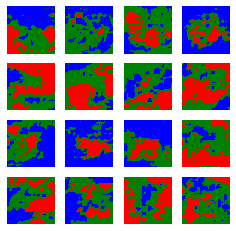

Time for training : 751 sec


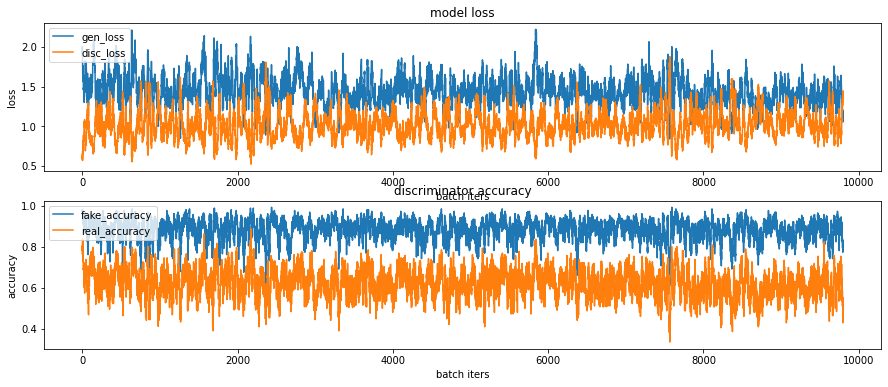

CPU times: user 12min 49s, sys: 1min 20s, total: 14min 10s
Wall time: 12min 32s


In [67]:
%%time
train(train_dataset, EPOCHS, save_every)

fake_accuracy의 움직이는 폭이 커졌고, 소폭 0.5에 가까워지긴 하였으나 여전히 1에 가깝게 유지되고 있습니다.  
GAN 훈련 과정을 개선하여 성능을 개선해보겠습니다.

## STEP 8. (optional) GAN 훈련 과정 개선하기
STEP 6을 진행하면서 생성된 샘플 이미지, 학습 과정 그래프 등을 통해 이전 훈련 과정의 문제점을 분석해 봅니다.
모델구조 또는 학습 과정을 개선한 내역과 그 결과(샘플 이미지, 학습 과정 그래프 포함)를 함께 제출합니다.
아래 페이지들에서 개선을 위한 아이디어를 얻어보았습니다.

- [How to Train a GAN? Tips and tricks to make GANs work](https://github.com/soumith/ganhacks)
- [10 Lessons I Learned Training GANs for one Year](https://towardsdatascience.com/10-lessons-i-learned-training-generative-adversarial-networks-gans-for-a-year-c9071159628)
- [Tips for Training Stable Generative Adversarial Networks](https://machinelearningmastery.com/how-to-train-stable-generative-adversarial-networks/)
- [Improved Techniques for Training GANs(paper)](https://proceedings.neurips.cc/paper_files/paper/2016/file/8a3363abe792db2d8761d6403605aeb7-Paper.pdf)

## 실험1 : BATCH_SIZE를 256에서 64로 변경 / 초기 EPOCHS을 50에서 100으로 설정
- [배치 사이즈 레퍼런스](https://developer-together.tistory.com/63)
- 에폭 : 초기 학습 시 50 에폭 이후 추가로 50에폭을 학습하였으므로, 이번 실험에서도 동일하게 100에폭으로 학습하였다.

In [69]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

# 미니 배치 학습 
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [70]:
save_every = 5
EPOCHS = 100

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

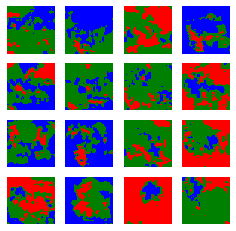

Time for training : 1522 sec


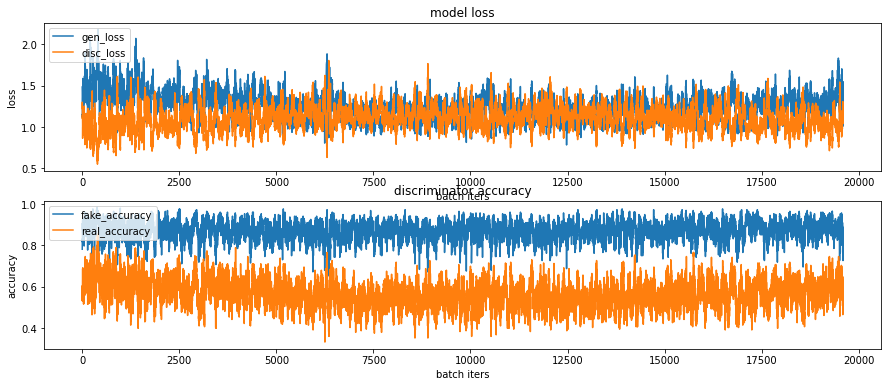

CPU times: user 25min 59s, sys: 2min 40s, total: 28min 39s
Wall time: 25min 23s


In [71]:
%%time
train(train_dataset, EPOCHS, save_every)

# 학습과정의 loss, accuracy 그래프 이미지 파일이 ~/aiffel/dcgan_newimage/cifar10/training_history 경로에 생성되고 있어
# 진행 과정을 수시로 확인할 수 있습니다.

실험 결과 초기 학습 결과에 비해  
- Loss : 생성자와 판별자의 로스가 1.0~1.5 사이로 모였다.
- Accurach : real_accuracy는 소폭 0.5에 가까워졌으나, fake_accuracy는 이전과 유사하다.

In [72]:
# 샘플 이미지들로 gif 파일 만들기

anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/cifar10_mnist_dcgan01.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/cifar10/cifar10_mnist_dcgan01.gif

-rw-r--r-- 1 root root 222205 Jan 23 07:51 /aiffel/aiffel/dcgan_newimage/cifar10/cifar10_mnist_dcgan01.gif


gif는 여전히 노이즈 형태로 보인다.

### GAN 모델구조, 학습과정 개선 표

|제목|내용|부가 설명|
|------|---|---|
|초기 모델|배치사이즈 256|초기값 에폭 50으로 학습 후 추가로 에폭 50으로 학습|
|실험 1|배치사이즈 64로 변경|초기값 에폭으로 100 설정|

---
## 회고
### KEEP
- GAN 모델링의 개념과 목표를 이해하며 진행했다.
- 레퍼런스를 참조하여 적절하다고 생각하는 방법으로 성능 개선을 시도해보았다. ([실험1 : 배치 사이즈 줄이기](https://developer-together.tistory.com/63))

### PROBLEM
- 이전에 학습한 모델에 비해 GAN은 모델 구현과 학습까지 많은 단계를 거치다보니 흐름을 보면 이해는 하지만 기억에 잘 남지 않는다.
- 초기 실험에서 추가로 학습하였으나 성능 개선이 잘 이루어지지 않았다.

### TRY
- 한글로 정리해둔 흐름을 계속 눈에 익히고, 코드로 여러 번 반복하여 구현해보기
- loss와 accuracy 그래프를 보며 개선되어야 할 부분이 어떤 것인지(ex. 생성자의 성능인지? 판별자의 성능인지?), 어떻게 개선할 수 있을지? 등을 생각해보고 여러 레퍼런스들을 참조하여 시도해보기 (모델 구조, learning_rate, 파라미터 초기화, 생성자와 판별자의 경쟁 관계, 데이터의 특성 등)

## Reference
- [지수 표기법 - 학습률 설정 시](https://izen8.tistory.com/902)
- [실험1 : 배치 사이즈 줄이기](https://developer-together.tistory.com/63)
- [How to Train a GAN? Tips and tricks to make GANs work](https://github.com/soumith/ganhacks)
- [10 Lessons I Learned Training GANs for one Year](https://towardsdatascience.com/10-lessons-i-learned-training-generative-adversarial-networks-gans-for-a-year-c9071159628)
- [Tips for Training Stable Generative Adversarial Networks](https://machinelearningmastery.com/how-to-train-stable-generative-adversarial-networks/)
- [Improved Techniques for Training GANs(paper)](https://proceedings.neurips.cc/paper_files/paper/2016/file/8a3363abe792db2d8761d6403605aeb7-Paper.pdf)

### 루브릭
1. GAN의 두 모델 구조를 통해 이미지를 성공적으로 생성하였다.	
오브젝트 종류를 육안으로 구별할 수 있을 만한 이미지를 생성하였다.
2. 생성 이미지 시각화 및 학습 그래프를 통해 GAN 학습이 바르게 진행되었음을 입증하였다.	
gif를 통해 생성이미지 품질이 서서히 향상되는 것과, fake accuracy가 추세적으로 0.5를 향해 하향하고 있음을 확인하였다.
3. 추가적인 GAN 모델구조 혹은 학습과정 개선 아이디어를 제안하고 이를 적용하였다.	
모델구조 변경 혹은 학습과정 개선 아이디어를 추가적으로 적용해보았고, 적용 전과 비교하였을 때의 내용을 표와 같은 시각적 자료로 작성하였다.